# Notebook for exercise 1 

## 1. Get data ready

### 1.1 Create train and test sets

In [35]:
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "8"  # This line erases a warning that i am getting
import numpy as np

file_names = []
files = []
#create X_train, y_train, X_test, y_test
X_train = np.full((50000,3072),0,dtype=int)
X_test = np.full((10000,3072),0,dtype=int)
y_train = np.full((50000,),0,dtype=int)
y_test = np.full((10000,),0,dtype=int)

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


for i in range(1,6):
    file = f"data_batch_{i}"
    file_names.append(file)

file_names.append("test_batch")

for file in file_names:
    cifar10_dict = unpickle(file)
    files.append(cifar10_dict)

i=0
for file in files:
    print(f"Append: {file[b'batch_label']}")
    if file[b'batch_label'] != b'testing batch 1 of 1':
        #this is the X_train, y_train
        X_train[i*10000:(i+1)*10000,:] = file[b'data']
        y_train[i*10000:(i+1)*10000] = file[b'labels'] 
        i+=1
       
    else:
        #i have just finished X_train, y_train   
        #this is the X_test, y_test
        X_test[:,:] = file[b'data']
        y_test[:] = file[b'labels']
        print(f"Shape X_train: {X_train.shape}\nShape y_train: {y_train.shape}")
        print(f"Shape X_test: {X_test.shape}\nShape y_test: {y_test.shape}\n")
        
        
    
    

Append: b'training batch 1 of 5'
Append: b'training batch 2 of 5'
Append: b'training batch 3 of 5'
Append: b'training batch 4 of 5'
Append: b'training batch 5 of 5'
Append: b'testing batch 1 of 1'
Shape X_train: (50000, 3072)
Shape y_train: (50000,)
Shape X_test: (10000, 3072)
Shape y_test: (10000,)



### 1.2 Preprocessing the data
From task 0 i am going to use:
* StandardScaler
* PCA

I have seen from the previous exercise that these two, improve my accuracy

In [36]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import torch

#Feature scaling
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

#PCA
pca = PCA(n_components=100)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

# Turn data into tensors
X_train = torch.from_numpy(X_train).type(torch.float)
X_test = torch.from_numpy(X_test).type(torch.float)
y_train = torch.from_numpy(y_train).type(torch.LongTensor)
y_test = torch.from_numpy(y_test).type(torch.LongTensor)






In [37]:
X_train.shape, X_test.shape

(torch.Size([50000, 100]), torch.Size([10000, 100]))

## 2 Build a model

### 2.1 Device agnostic code

In [38]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### 2.2 Build model



In [71]:
from torch import nn
NUM_FEATURES = X_train.shape[1]  # NUM_FEATURES = columns
NUM_CLASSES = 10

#Below i will use only linear layers (No ReLU)
class linear_model(nn.Module):
    def __init__(self,input_features,output_features,hidden_units):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features,out_features=hidden_units),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.Linear(in_features=hidden_units,out_features=output_features)            
        )

    def forward(self,x):
        return self.linear_layer_stack(x)

# Create an instance of model_1 and send it to the target device
model1_linear = linear_model(input_features=NUM_FEATURES,
                  output_features=NUM_CLASSES,
                  hidden_units=512).to(device)

model1_linear

linear_model(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=100, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=10, bias=True)
  )
)

### 2.3 Create Loss function and Optimizer

* I am wokring on a multiclass classification problem, so i will use the `nn.CrossEntropyLoss()` method as my loss function.
* For the optimizer i will use the Stochastic Gradient Descent (`SGD`)

In [72]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model1_linear.parameters(),
                            lr=0.1)


### 2.4 Create train and test loop function

In [73]:
#put the data to target device
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

class my_Metrics:
    def __init__(self, epochs):
        self.epochs = epochs
        self.train_loss_values = np.full((epochs), np.nan)
        self.test_loss_values = np.full((epochs), np.nan)
        self.train_acc_values = np.full((epochs), np.nan)
        self.test_acc_values = np.full((epochs), np.nan)

    def reset(self):
        self.train_loss_values[:] = np.nan
        self.test_loss_values[:] = np.nan
        self.train_acc_values[:] = np.nan
        self.test_acc_values[:] = np.nan
    
    

In [74]:
from sklearn.metrics import accuracy_score 
import time

def train_test_fn(model,epochs,X_train,X_test,y_train,y_test,metrics):
    metrics.reset() # Reset metrics before each call
    start_time = time.time()  # Start the timer
    
    for epoch in range(epochs):
        ### Training
        model.train()
        #1. Forward pass
        y_logits = model(X_train)
        y_pred = torch.softmax(y_logits,dim=1).argmax(dim=1) # logits -> pred probabilities -> pred labels
        #2. Calculate loss and accuracy
        loss = loss_fn(y_logits,y_train)
        metrics.train_loss_values[epoch] = loss
        # train_loss_values[epoch] = loss
        acc = accuracy_score(y_train.cpu(),y_pred.cpu())
        metrics.train_acc_values[epoch] = acc
        # train_acc_values[epoch] = acc
        #3. Optimizer zero grad
        optimizer.zero_grad()
        #4. Loss backwards
        loss.backward()
        #5.Optimizer step
        optimizer.step()
    
        ###Testing
        model.eval()
        with torch.inference_mode():
            #1. Forward pass
            test_logits = model(X_test)
            test_pred = torch.softmax(test_logits,dim=1).argmax(dim=1)
            #2. Calculate the test loss and accuracy
            test_loss = loss_fn(test_logits,y_test)
            metrics.test_loss_values[epoch] = test_loss
            # test_loss_values[epoch] = test_loss
            test_acc = accuracy_score(y_test.cpu(),test_pred.cpu())
            metrics.test_acc_values[epoch] = test_acc
            # test_acc_values[epoch] = test_acc

        #Print the results
        if epoch % 10 == 0 or epoch == epochs-1:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

    end_time = time.time()  # End the timer
    total_time = end_time - start_time  # Calculate total time
    print(f"Training completed in: {total_time:.2f} seconds")





In [75]:
epochs =100

# Create a metrics object
metrics = my_Metrics(epochs=epochs)

train_test_fn(model=model1_linear,
              epochs=epochs,
              X_train=X_train,
              X_test=X_test,
              y_train=y_train,
              y_test=y_test,
              metrics = metrics)

Epoch: 0 | Loss: 2.74358, Acc: 0.13% | Test Loss: 8.30989, Test Acc: 0.16%
Epoch: 10 | Loss: 1.83853, Acc: 0.35% | Test Loss: 1.81888, Test Acc: 0.36%
Epoch: 20 | Loss: 1.76485, Acc: 0.39% | Test Loss: 1.76430, Test Acc: 0.39%
Epoch: 30 | Loss: 1.74846, Acc: 0.40% | Test Loss: 1.74964, Test Acc: 0.39%
Epoch: 40 | Loss: 1.74158, Acc: 0.40% | Test Loss: 1.74336, Test Acc: 0.40%
Epoch: 50 | Loss: 1.73828, Acc: 0.40% | Test Loss: 1.74052, Test Acc: 0.40%
Epoch: 60 | Loss: 1.74183, Acc: 0.40% | Test Loss: 1.74569, Test Acc: 0.40%
Epoch: 70 | Loss: 1.74937, Acc: 0.40% | Test Loss: 1.75012, Test Acc: 0.39%
Epoch: 80 | Loss: 1.73797, Acc: 0.40% | Test Loss: 1.73967, Test Acc: 0.40%
Epoch: 90 | Loss: 1.73421, Acc: 0.40% | Test Loss: 1.73636, Test Acc: 0.40%
Epoch: 99 | Loss: 1.73295, Acc: 0.40% | Test Loss: 1.73524, Test Acc: 0.40%
Training completed in: 3.53 seconds


## 3. Save the model_1 in `Ex1_Models` folder

In [76]:
from pathlib import Path

def save_model(model,model_name):
    #1. Create models directory
    MODEL_PATH = Path("Ex1_Models")
    MODEL_PATH.mkdir(parents=True, exist_ok=True)
    
    #2. Create model save path
    MODEL_NAME = model_name
    MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
    
    #3. save the model state dict
    print(f"Saving model to:{MODEL_SAVE_PATH}")
    torch.save(obj=model.state_dict(),f=MODEL_SAVE_PATH)


In [77]:
save_model(model=model1_linear,
           model_name="model1_linear.pth")

Saving model to:Ex1_Models\model1_linear.pth


## 4. Plot the model

In [79]:
import matplotlib.pyplot as plt

def plot_loss_acc_fn(metrics,model_name):
    plt.figure(figsize=(12, 8))
    plt.subplot(2,1,1)
    plt.plot(metrics.train_loss_values,label="Train Loss")
    plt.plot(metrics.test_loss_values,label="Test Loss")
    plt.title("Train Loss vs Test Loss (" + model_name + ")" ,fontsize=14,fontweight="bold")
    plt.xlabel("Epochs")
    plt.ylabel("Loss values")
    plt.grid(alpha=0.3)
    plt.legend()
    
    plt.subplot(2,1,2)
    plt.plot(metrics.train_acc_values,label="Train Accuaracy")
    plt.plot(metrics.test_acc_values,label="Test Accuracy")
    plt.title("Train Accuracy vs Test Accuracy",fontsize=14,fontweight="bold")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy values")
    plt.grid(alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    
    

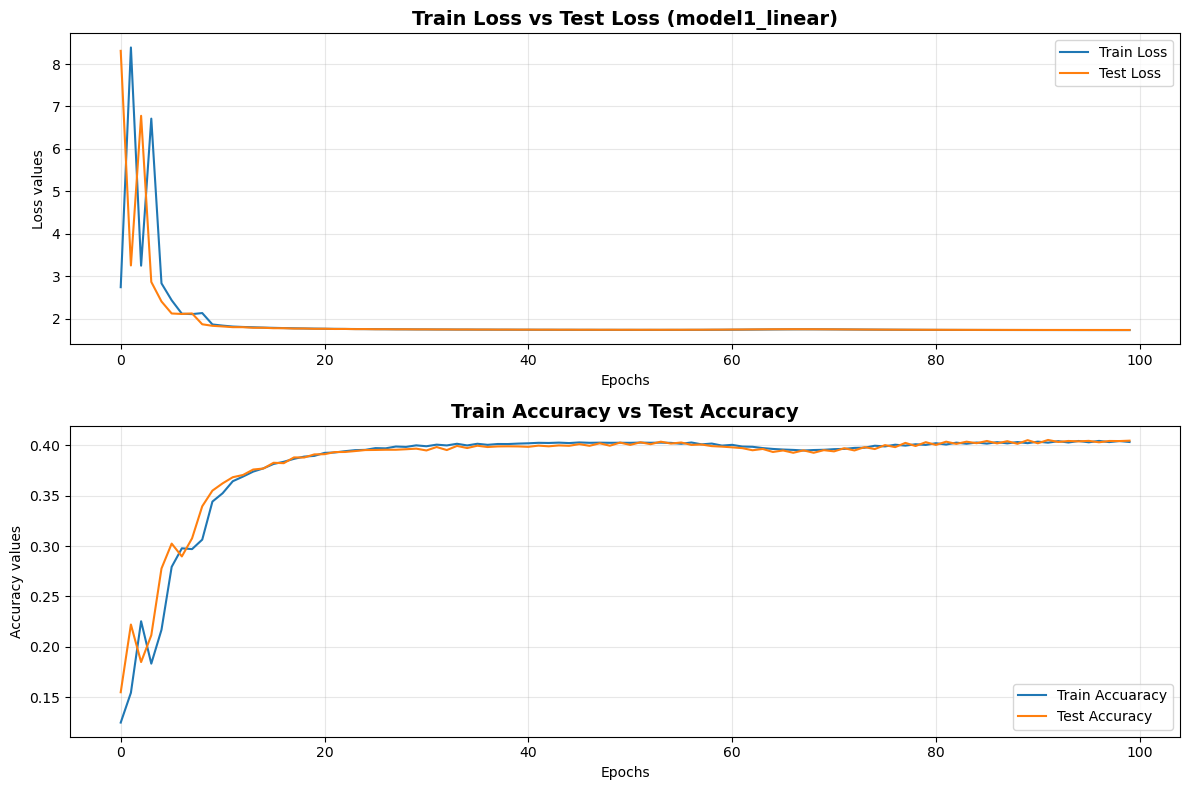

In [81]:
plot_loss_acc_fn(metrics=metrics,
                 model_name="model1_linear")